In [ ]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import os

In [71]:
# =============================
# 1. Cargar y limpiar los datos
# =============================

# Cargar dataset preprocesado y el base train/test
df = pd.read_csv('../data/procesed/df_master_clean.csv')
df_tr = pd.read_csv('../data/raw/prueba_op_base_pivot_var_rpta_alt_enmascarado_trtest.csv')

# Filtrar columnas comunes + 'id'
columns_to_keep = df.columns.intersection(df_tr.columns).tolist()
if 'id' in df.columns:
    columns_to_keep.append('id')
df = df[columns_to_keep]

# Eliminar columna no deseada si existe
df.drop(columns=['tipo_var_rpta_alt'], inplace=True, errors='ignore')

# Separar variables independientes y objetivo
X = df.drop(columns=['var_rpta_alt', 'id'])
y = df['var_rpta_alt']

print(f"🔹 X shape: {X.shape}")
print(f"🔹 y shape: {y.shape}")


🔹 X shape: (100466, 47)
🔹 y shape: (100466,)


In [72]:
# ================================
# 2. Preprocesamiento con Pipeline
# ================================

# Identificar tipos de columnas
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Pipelines
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))])

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Aplicar transformaciones
X_preprocessed = preprocessor.fit_transform(X)
print(f"🔹 X_preprocessed shape: {X_preprocessed.shape}")

🔹 X_preprocessed shape: (100466, 218)


In [73]:
# ==================================
# 3. Eliminar colinealidad (> 0.9)
# ==================================

# Reconstruir nombres de columnas transformadas
onehot_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(onehot_feature_names)

# Convertir a DataFrame
X_preprocessed_df = pd.DataFrame(
    X_preprocessed.toarray() if hasattr(X_preprocessed, "toarray") else X_preprocessed,
    columns=all_feature_names,
    index=X.index
)

# Calcular matriz de correlación
corr_matrix = X_preprocessed_df.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Eliminar una de cada par altamente correlacionado
correlation_threshold = 0.9
high_corr_cols = [col for col in upper_tri.columns if any(upper_tri[col] > correlation_threshold)]

print(f"📌 Variables eliminadas por colinealidad: {len(high_corr_cols)}")
X_nocolineal = X_preprocessed_df.drop(columns=high_corr_cols)

print(f"✅ Shape después de quitar colinealidad: {X_nocolineal.shape}")


📌 Variables eliminadas por colinealidad: 69
✅ Shape después de quitar colinealidad: (100466, 149)


In [74]:
# ======================================
# 4. Selección de variables con Lasso
# ======================================

# Entrenar modelo L1
lasso_model = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    random_state=42,
    max_iter=1000,
    C=1.0
)
lasso_model.fit(X_nocolineal, y)

# Umbral para coeficientes ≠ 0
non_zero_coefs = lasso_model.coef_[0][lasso_model.coef_[0] != 0]
min_non_zero_coef = np.min(np.abs(non_zero_coefs)) - 1e-6

# Aplicar selección
selector = SelectFromModel(estimator=lasso_model, prefit=True, threshold=min_non_zero_coef)
X_selected = selector.transform(X_nocolineal)
selected_mask = selector.get_support()
selected_features = np.array(X_nocolineal.columns)[selected_mask]

print(f"✅ Variables seleccionadas por Lasso: {X_selected.shape[1]} de {X_nocolineal.shape[1]}")


✅ Variables seleccionadas por Lasso: 44 de 149


d:\Desktop\juan_guzma_prueba_banco\env\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


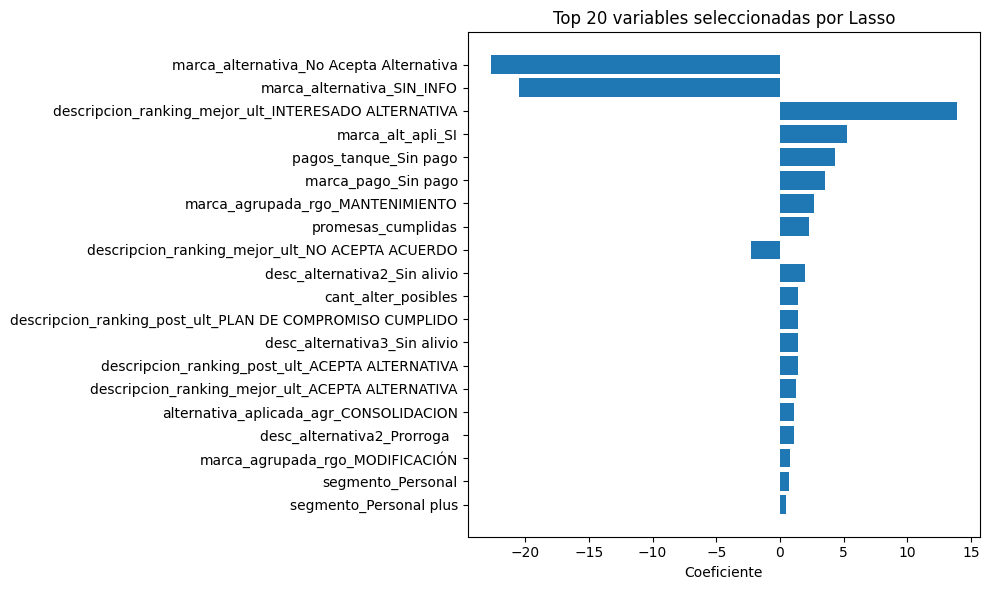

In [75]:
# ==========================================
# 5. Exportar ranking de variables Lasso
# ==========================================

coefficients = lasso_model.coef_[0]
coef_df = pd.DataFrame({
    'feature': X_nocolineal.columns,
    'coefficient': coefficients
})
coef_df = coef_df[coef_df['coefficient'] != 0]
coef_df['abs_coefficient'] = coef_df['coefficient'].abs()
coef_df = coef_df.sort_values(by='abs_coefficient', ascending=False)

# Graficar top 20
plt.figure(figsize=(10, 6))
plt.barh(coef_df['feature'].iloc[:20], coef_df['coefficient'].iloc[:20])
plt.xlabel('Coeficiente')
plt.title('Top 20 variables seleccionadas por Lasso')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Exportar ranking
os.makedirs('../data/procesed', exist_ok=True)
coef_df[['feature']].to_csv('../data/procesed/features.csv', index=False)

In [76]:
# ===================================
# 6. Exportar DataFrame final limpio
# ===================================

# Crear DataFrame final
X_nocolineal_df = X_nocolineal.copy()
df_final = pd.concat([
    df[['id']],
    y,
    X_nocolineal_df[selected_features]
], axis=1)

df_final.to_csv('../data/procesed/df_procesed.csv', index=False)
print(f"✅ DataFrame final exportado. Shape: {df_final.shape}")

✅ DataFrame final exportado. Shape: (100466, 46)
